In [1]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt

In [2]:
# Carregar a base de dados
file_path = 'supermarket_sales.csv'  # Atualize para o caminho correto do arquivo
data = pd.read_csv(file_path)

# Inspecionar as primeiras linhas para entender a estrutura
data.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [3]:
# Agrupar transações por Branch e Date
transactions = data.groupby(['Branch', 'Date'])['Product line'].apply(list).tolist()

# Converter para formato binário
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Aplicar Apriori com suporte reduzido
frequent_itemsets = apriori(df, min_support=0.001, use_colnames=True)

# Verificar itemsets frequentes com mais de um item
print("Itemsets Frequentes com Mais de Um Item:")
print(frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x) > 1)])





Itemsets Frequentes com Mais de Um Item:
     support                                           itemsets
6   0.273764      (Electronic accessories, Fashion accessories)
7   0.224335       (Electronic accessories, Food and beverages)
8   0.193916        (Electronic accessories, Health and beauty)
9   0.220532       (Home and lifestyle, Electronic accessories)
10  0.254753        (Sports and travel, Electronic accessories)
11  0.258555          (Food and beverages, Fashion accessories)
12  0.235741           (Health and beauty, Fashion accessories)
13  0.243346          (Home and lifestyle, Fashion accessories)
14  0.273764           (Sports and travel, Fashion accessories)
15  0.205323            (Food and beverages, Health and beauty)
16  0.209125           (Home and lifestyle, Food and beverages)
17  0.228137            (Sports and travel, Food and beverages)
18  0.186312            (Home and lifestyle, Health and beauty)
19  0.201521             (Sports and travel, Health and beauty)

In [4]:
# Gerar regras de associação
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2, num_itemsets=len(frequent_itemsets))

# Exibir as regras encontradas
if not rules.empty:
    print("\nRegras de Associação:")
    print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
else:
    print("Nenhuma regra encontrada.")


Regras de Associação:
                                           antecedents  \
0                             (Electronic accessories)   
1                                (Fashion accessories)   
2                             (Electronic accessories)   
3                                 (Food and beverages)   
4                             (Electronic accessories)   
..                                                 ...   
406  (Health and beauty, Electronic accessories, Fa...   
407  (Home and lifestyle, Electronic accessories, H...   
408  (Health and beauty, Food and beverages, Fashio...   
409  (Home and lifestyle, Food and beverages, Healt...   
410  (Health and beauty, Home and lifestyle, Fashio...   

                                           consequents   support  confidence  \
0                                (Fashion accessories)  0.273764    0.562500   
1                             (Electronic accessories)  0.273764    0.517986   
2                                 (Food 

In [7]:
# Filtrar regras com lift > 1
rules_filtered = rules[rules['lift'] > 1]

# Classificar regras por confiança
rules_sorted = rules_filtered.sort_values(by='confidence', ascending=False)

# Exibir as 10 principais regras
print("\nTop 10 Regras de Associação com Lift > 1:")
print(rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

# Focar em regras com 'Health and beauty' nos antecedentes
target_rules = rules_sorted[rules_sorted['antecedents'].astype(str).str.contains('Health and beauty')]

print("\nRegras Específicas para 'Health and beauty':")
print(target_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


Top 10 Regras de Associação com Lift > 1:
                                      antecedents               consequents  \
79   (Home and lifestyle, Electronic accessories)       (Sports and travel)   
102        (Sports and travel, Health and beauty)     (Fashion accessories)   
90       (Home and lifestyle, Food and beverages)     (Fashion accessories)   
36    (Electronic accessories, Health and beauty)     (Fashion accessories)   
42   (Home and lifestyle, Electronic accessories)     (Fashion accessories)   
115      (Home and lifestyle, Food and beverages)       (Sports and travel)   
80    (Sports and travel, Electronic accessories)      (Home and lifestyle)   
109     (Home and lifestyle, Fashion accessories)       (Sports and travel)   
78        (Home and lifestyle, Sports and travel)  (Electronic accessories)   
30   (Electronic accessories, Food and beverages)     (Fashion accessories)   

      support  confidence      lift  
79   0.155894    0.706897  1.408438  
102  0.1330

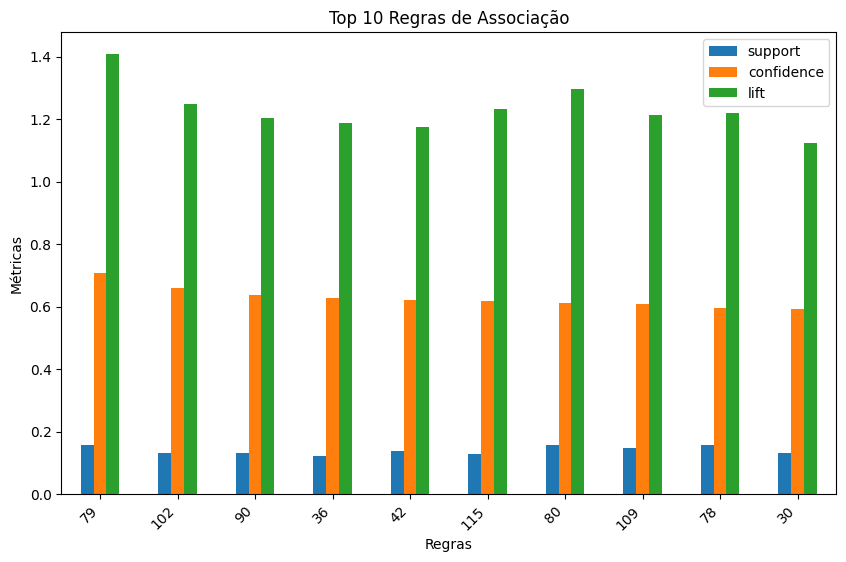

In [8]:
import matplotlib.pyplot as plt

top_rules = rules_sorted.head(10)
top_rules[['support', 'confidence', 'lift']].plot(kind='bar', figsize=(10, 6))
plt.title('Top 10 Regras de Associação')
plt.xlabel('Regras')
plt.ylabel('Métricas')
plt.xticks(rotation=45, ha='right')
plt.show()


In [10]:
import requests
import time

HF_API_URL = "https://api-inference.huggingface.co/models/pierreguillou/gpt2-small-portuguese"
HF_API_TOKEN = ""
headers = {"Authorization": f"Bearer {HF_API_TOKEN}"}


payload = {"inputs": "Qual a previsão de vendas para este mês no supermercado?"}

while True:
    response = requests.post(HF_API_URL, headers=headers, json=payload)
    if response.status_code == 503:
        print("Modelo ainda está carregando. Tentando novamente em 10 segundos...")
        time.sleep(10)
    else:
        break

if response.status_code == 200:
    print(response.json()[0]['generated_text'])
else:
    print(f"Erro na API: {response.status_code} - {response.text}")

Qual a previsão de vendas para este mês no supermercado?
Maria João Diniz de Oliveira, ou simplesmente Maria Diniz de Oliveira, foi uma cantora de MPB evida que gravou sua versão de Samurais no Rádio Mayrink Veiga, em 3 de março de 1932. Em clipes casados (pocket shows) e sexy (charadas-chefe e dança do show) em parceria com Marcos Frota.

Como cantora principal da Rádio Mayrink Veiga, tentou para abrir um espaço para a juventude na crítica, juntamente com Geraldo Vandré e outros músicos, fazendo apresentações livre. Entre os musicais mais conhecidos da época foi "Manhã cheia", interpretada pela cantora lírica de Emerson Fittipaldi, e depois "Luz", da cantora lírica entre os anos de 1950 e 1960, e "Mais uma Vez", single que o grupo João & José regravou em 2006.

Como cantora, 1910 representa tempos onerosos a nível político e teatral que desejava dar à década de 30. Dessa época, tocaria-se como "judeu" ou "donzela direita", sempre ligada ao teatro e música, ao cinema e à propaganda ele